<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multivariate-toy-example" data-toc-modified-id="Multivariate-toy-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multivariate toy example</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Proposal-of-general-Reducer-class" data-toc-modified-id="Proposal-of-general-Reducer-class-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Proposal of general Reducer class</a></span></li></ul></div>

## Multivariate toy example


Data `DailyDelhiClimateTrain.csv` from

https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data/version/1/tasks

In [79]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import warnings
warnings.filterwarnings('ignore')

In [80]:
df = pd.read_csv("./data/DailyDelhiClimateTrain.csv")

In [81]:
cols = df.columns

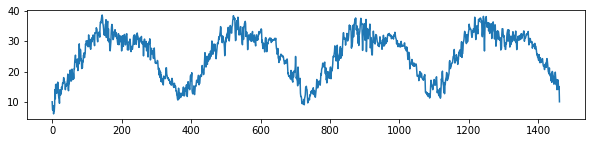

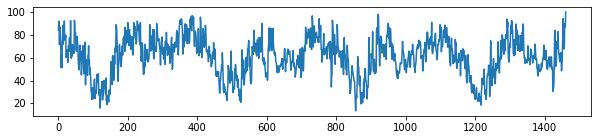

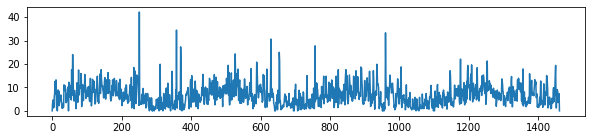

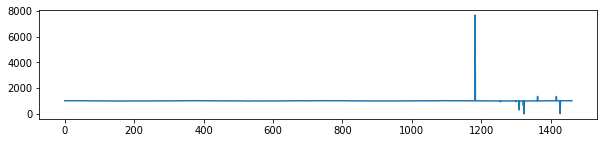

In [82]:
for col in cols:
    plt.figure(figsize=(10,2))
    plt.plot(df[col])

## Train test split

In [83]:
n_samples = len(df)
train_size_percentage = 0.75
train_size = int(n_samples * train_size_percentage)
test_size = n_samples - train_size
fh = np.arange(test_size) + 1
assert len(fh) == test_size, "fh should be equal to the length of the test set"

1096 366


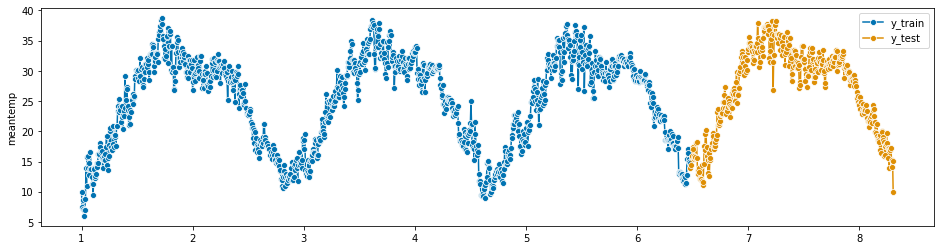

In [92]:
y_train, y_test = temporal_train_test_split(df[cols[0]], test_size=test_size)
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

Here we should update `temporal_train_test_split` to handle dataframes.

df_train, df_test = temporal_train_test_split(df, test_size=test_size)

In [101]:
def temporal_train_test_split(df, test_size):
    if isinstance(df, pd.DataFrame):
        df_train = df[0:-test_size]
        df_test = df[-test_size:]
        return df_train, df_test
    

In [105]:
df_train, df_test = temporal_train_test_split(df, test_size=test_size)

## Proposal of general Reducer class

The following class can be used to learn from a  dataframe storing a multivariate timeseries

In [106]:
from sktime.forecasting.naive import NaiveForecaster
import copy

In [270]:
def _check_forecaster(forecaster):
    # check forecaster is univariate forecaster
    pass



class Reducer:
    """
    Class for using several copies of the same univariate forecaster 
    for each of the columns in the input data.
    
    This class reduces the multivariate forecasting problem to an
    `n_variables` forecasting problem.
    """
    
    def __init__(self, forecaster):
        self.forecaster = forecaster
        
    def fit(self, Y, X=None, fh=None):
        self.n_variables = Y.shape[1]
        self.forecasters_ = []
        self.last_index = Y.index[-1]
        self.columns = Y.columns
        
        for i, col in enumerate(Y):
            f = copy.deepcopy(self.forecaster)
            f.fit(Y[col])
            self.forecasters_.append(f)
                 
        self._is_fitted = True
        return self
            
    def predict(self, fh=None, X=None):
        y = np.empty((len(fh), self.n_variables))
        
        for i, f in enumerate(self.forecasters_):
            y[:, i] = f.predict(fh)
                    
        index_ = pd.RangeIndex(start=self.last_index,stop=self.last_index+len(fh),step=1)
        df_pred =  pd.DataFrame(y, index= index_,columns=self.columns) 
       
        return df_pred
    
    def update(self, Y, X=None):
        # online learning
        for f in enumerate(self.forecasters_):
            f.update(y, X=None)
            
        return self


In [277]:
uf = NaiveForecaster()

multivariate_reducer = Reducer(uf)
multivariate_reducer.fit(df_train)
df_pred = multivariate_reducer.predict(fh)

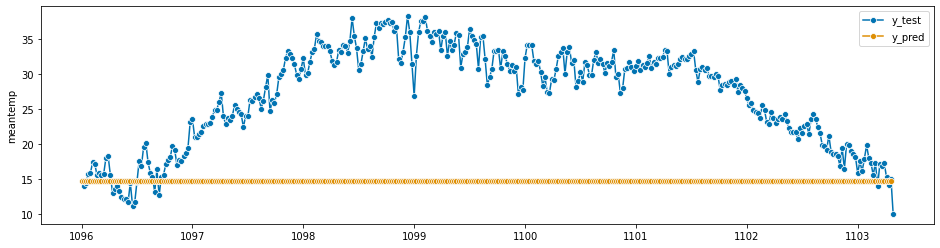

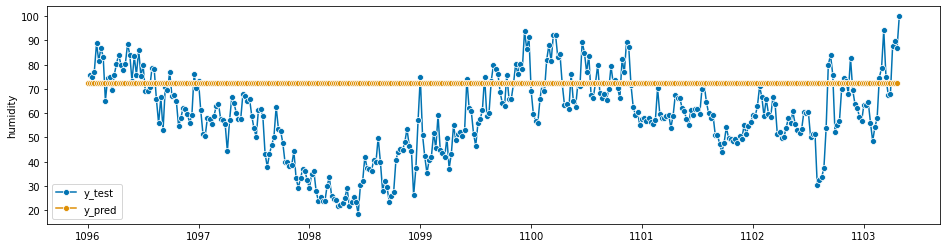

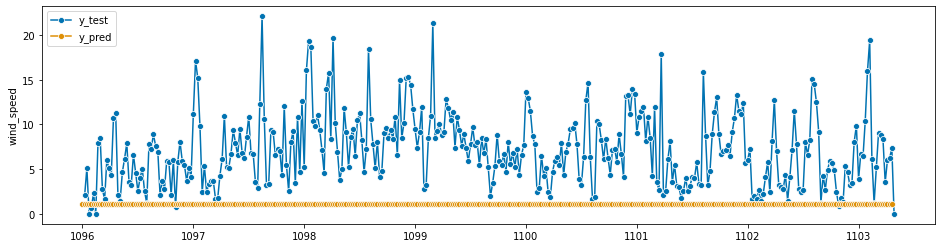

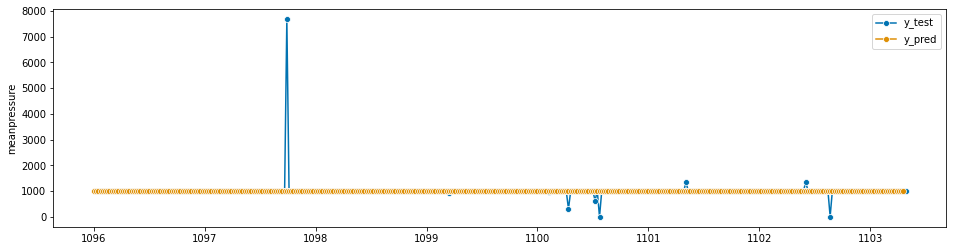

In [278]:
for col in cols:
    #plt.figure(figsize=(10,1))
    plot_series(df_test[col], df_pred[col],
                labels=[ "y_test", "y_pred"])
